# Solitaire Gameplay (Strategic Version)

Use `random.seed(84)` for win state.

In [1]:
import pprint
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Card:

    def __init__(self, suit, value):
        """Initialize the Card class. Each card belongs to a suit, has
        a value, and can be flipped or not.
        """
        self.suit = suit
        self.value = value
        self.flipped = False

    def flip(self):
        """Flip a card. If a card is currently face_down, set it to face_up,
        and vice versa.
        """
        self.flipped = not self.flipped

    def __str__(self):
        """Return the suit and value of a card, e.g. "3 ♠".
        """
        return(f"{self.value} {self.suit}")

In [3]:
class Deck:

    def __init__(self, values, suits):
        self.cards = []
        self.cache = []
        self.populate(values, suits)
        self.shuffle()

    def __str__(self):
        return ", ".join([str(card) for card in self.cards])

    def populate(self, values, suits):
        for suit in suits:
            for value in values:
                this_card = Card(suit, value)
                self.cards.append(this_card)

    def shuffle(self):
        """Reproducible results.
        To test strategy one, use seed=4.
        To test strategy two, use seed=7.
        """
        random.seed(seed)
        random.shuffle(self.cards)

    def get_first_card(self):
        if len(self.cards) > 0:
            return self.cards[0]
        else:
            return None

    def take_first_card(self, flip=True):
        if len(self.cards) > 0:
            next_card = self.cards.pop(0)
            if flip and len(self.cards) > 0:
                self.cards[0].flip()
            return next_card
        else:
            return None

    def draw_card(self):
        if len(self.cards) > 0:
            self.cards[0].flip()
            self.cards.append(self.cards.pop(0))
            self.cards[0].flip()

In [4]:
class Stack:

    def __init__(self):
        """Initialize the Stack class.
        """
        self.cards = []

    def add_card(self, Card):
        """Add a card to a stack. Inserts the card into the first position.
        """
        self.cards.insert(0, Card)

    def flip_first_card(self):
        """Flip the first card in the stack if there are cards in the stack.
        """
        if len(self.cards) > 0:
            self.cards[0].flip()

    def get_face_up_cards(self):
        """Return the cards in the stack that are currently face_up.
        """
        return [card for card in self.cards if card.flipped]

    def __str__(self):
        """Return the current stack as the number of face_down cards and then
        each face_up card by value and suit.
        """
        returned_cards = [str(card) for card in reversed(
            self.get_face_up_cards())]
        face_down_count = len(self.cards) - len(self.get_face_up_cards())
        if face_down_count > 0:
            returned_cards.insert(0, f"{face_down_count} cards face down.")
        return ", ".join(returned_cards)

In [5]:
class Game:

    values = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

    suits = { # Keys are unicode symbols for suits.
        u'\u2660': "black", # Spade
        u'\u2661': "red", # Hearts
        u'\u2663': "black", # Clubs
        u'\u2662': "red", # Diamonds
    }

    def __init__(self):
        """Initialize the Game class.
        """
        self.moves = 0
        
        # Instantiate the Deck.
        self.deck = Deck(self.values, self.suits)

        # Instantiate the Stacks.
        self.play_stacks = []

        # For each of the seven stacks...
        for i in range(7):
            this_stack = Stack()
            # ...take the first card from the Deck without flipping it and add
            # it to the current stack by inserting it into the first position.
            # The first stack will have 1 card, the second 2...the last, 7.
            [this_stack.add_card(self.deck.take_first_card(flip=False))
             for j in range(i + 1)]
            # Flip the topmost card in the stack.
            this_stack.flip_first_card()
            # Add the populated stack to the list of playable stacks.
            self.play_stacks.append(this_stack)

        # Populate the four Ace stacks.
        self.ace_stacks = {suit: Stack() for suit in self.suits}

        # Flip the first card in the Deck.
        self.deck.cards[0].flip()

    def show_board(self):
        board = {
            "deck": str(self.deck),
            "stacks": [str(stack) for stack in self.play_stacks],
            "ace stacks": {suit: str(stack) for suit, stack in
                           self.ace_stacks.items()}
        }
        return board

    def check_card_order(self, higher, lower):
        """Determine whether or not two cards can be placed consecutively. Make
        sure that both cards are of differing suits with suits_different. Then,
        ensure that the cards are consecutive with values_consecutive by check-
        ing that the value of the higher card is exactly one more than the
        value of the lower one. If both criteria are met, then the card order
        is allowed.
        """
        suits_different = self.suits[higher.suit] != self.suits[lower.suit]
        values_consecutive = self.values[self.values.index(higher.value)
                                        - 1] == lower.value
        return suits_different and values_consecutive

    def win(self):
        """Determine when the game is won. Deck must be empty, stacks must be
        empty, and Ace stacks must be full.
        """
        deck_empty = len(self.deck.cards) == 0
        stacks_empty = all(len(stack.cards) == 0 for stack in self.play_stacks)
        aces_full = all(len(stack.cards) == 13 for suit,
                        stack in self.ace_stacks.items())
        return deck_empty and stacks_empty and aces_full

    def add_to_ace_stack(self, card):
        """See if the current card can be added to the corresponding Ace stack.
        """
        if card is None: # do nothing if there is no current card
            return False
        # If there are cards in the Ace stack...
        elif len(self.ace_stacks[card.suit].cards) > 0:
            # ...get the value of topmost card.
            highest_value = self.ace_stacks[card.suit].cards[0].value
            # Check if value of the current card is higher than the topmost.
            if self.values[self.values.index(highest_value) + 1] == card.value:
                # If so, play the card to the corresponding Ace stack.
                self.ace_stacks[card.suit].cards.insert(0, card)
                return True
        else:
            return False
    
    def play_strategy_one(self):
        """Always play an Ace or Deuce wherever you can immediately.
        """
        card_added = self.deck.get_first_card()
        
        #--- 1.1 Always play an Ace wherever you can immediately. ---#
        
        # Play an Ace from the deck to its own stack.
        if card_added is not None and card_added.value == "A":
            card_added = self.deck.take_first_card()
            self.ace_stacks[card_added.suit].cards.insert(0, card_added)
            if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from deck to Ace stack")
            return True
        
        # Play an Ace from the board to its own stack.
        for stack in np.random.permutation(self.play_stacks):
            if len(stack.cards) > 0 and stack.cards[0].value == "A":
                card_added = stack.cards.pop(0)
                self.ace_stacks[card_added.suit].cards.insert(0, card_added)
                if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from board to Ace stack")
                return True
        
        #--- 1.2 Always play a Deuce wherever you can immediately. ---#
        
        # Play a Deuce from the deck to an Ace stack.
        if card_added is not None and card_added.value == "2":
            if self.add_to_ace_stack(self.deck.get_first_card()):
                card_added = self.deck.take_first_card()
                if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from deck to Ace stack")
                return True

        # Play a Deuce from the board to an Ace stack.
        for stack in np.random.permutation(self.play_stacks):
            if len(stack.cards) > 0 and stack.cards[0].value == "2":
                if self.add_to_ace_stack(stack.cards[0]):
                    card_added = stack.cards.pop(0)
                    if verbose == True:
                        print(f"Move {self.moves}: Play {str(card_added)} from board to Ace stack")
                    return True
        return False
    
    def play_strategy_two(self):
        """Always make the play or transfer that frees (or allows a play that frees) a downcard,
        regardless of any other considerations. To debug, use seed=7. all_face_ups helps to implement strategy
        three.
        """
        all_face_ups = [(self.suits[stack.get_face_up_cards()[-1].suit], stack.get_face_up_cards()[-1].value) if len(stack.get_face_up_cards()) > 0 else ('', '') for stack in self.play_stacks]
        
        # For each stack in the deck...
        for index, stack in enumerate(np.random.permutation(self.play_stacks)):
            # ...get the number of face down cards.
            stack_face_up = stack.get_face_up_cards()
            num_stack_face_down = len(stack.cards) - len(stack_face_up)

            if num_stack_face_down > 0:
                stack_first_face_up = (self.suits[stack_face_up[-1].suit], stack_face_up[-1].value)
                
                # If there's only one card on it, check if it can be played to an ace stack.
                if len(stack_face_up) == 1 and self.add_to_ace_stack(stack_face_up[0]):
                        card_added = stack.cards.pop(0)
                        if verbose == True:
                            print(f"Move {self.moves}: Play {str(card_added)} from board to Ace stack")
                        return True
                # Else, try to move the stack somewhere else.
                else:
                    # Check all the available stacks.
                    for pile in np.random.permutation(self.play_stacks):
                        # Get all the face_up cards in the pile.
                        pile_face_up = pile.get_face_up_cards()
                        # Skip the current stack.
                        if pile is not stack and len(pile_face_up) > 0:
                            cards_to_move = stack_face_up[:len(stack_face_up)]
                            # If the card can be moved
                            if self.check_card_order(pile.cards[0], cards_to_move[-1]):
                                # Check if there's an alternative
                                locs = np.where([i == stack_first_face_up for i in all_face_ups])[0]
                                # If there's a better alternative, skip this stack since we'll reach the better
                                # choice as the loop continues
                                if len(locs) == 2 and not self.play_strategy_three(stack, self.play_stacks[locs[-1]]):
                                    break
                                else:
                                    if verbose == True:
                                        print("Stack:", [(card.suit, card.value) for card in stack_face_up], "\nPile:",  [(card.suit, card.value) for card in pile_face_up])
                                        print("Cards to move:", [(card.suit, card.value) for card in cards_to_move])
                                    [pile.cards.insert(0, card) for card in reversed(cards_to_move)]
                                    stack.cards = stack.cards[len(cards_to_move):]
                                    if verbose == True:
                                        print(f"Move {self.moves}: Move {len(cards_to_move)} cards between piles")
                                    return True
        return False

    def play_strategy_three(self, chosen_stack, alternate_stack):
        """When faced with a choice, always make the play or transfer that frees (or allows a play that frees)
        the downcard from the biggest pile of downcards. To debug, use seed=3.
        """
        chosen_stack_face_down = len(chosen_stack.cards) - len(chosen_stack.get_face_up_cards())
        alternate_stack_face_down = len(alternate_stack.cards) - len(alternate_stack.get_face_up_cards())
        return chosen_stack_face_down >= alternate_stack_face_down
    
    def play_strategy_four(self, cards):
        """Transfer cards from column to column only to allow a downcard to be freed or to make the columns
        smoother. To debug, use seed=1.
        """
        # Return the suits of the given cards.
        return [(card.suit, card.value) for card in cards[1::2]]
    
    def play_strategy_five(self):
        """Don't clear a spot unless there's a King IMMEDIATELY waiting to occupy it. To debug, use seed=1.
        """
        king_waiting = self.play_strategy_six()
        
        if king_waiting:
        
            for index, stack in enumerate(np.random.permutation(self.play_stacks)):
                stack_face_up = stack.get_face_up_cards()
                num_stack_face_down = len(stack.cards) - len(stack_face_up)
                # If the stack is already empty
                if num_stack_face_down == 0 and len(stack_face_up) == 0:
                    if king_waiting < 0:
                        card_added = self.deck.take_first_card()
                        stack.add_card(card_added)
                        if verbose == True:
                            print(f"Move {self.moves}: Move {str(card_added)} from deck to empty stack")
                        return True
                    else:
                        cards_to_move = self.play_stacks[king_waiting].get_face_up_cards()
                        # Move to empty stack
                        [stack.cards.insert(0, card) for card in reversed(cards_to_move)]
                        self.play_stacks[king_waiting].cards = self.play_stacks[king_waiting].cards[len(cards_to_move):]
                        if verbose == True:
                            print(f"Move {self.moves}: Move cards from board to empty stack")
                        return True
                # If there's only one card in the stack
                elif num_stack_face_down == 1 and len(stack_face_up) == 1:
                    if self.add_to_ace_stack(stack_face_up[0]):
                            card_added = stack.cards.pop(0)
                            if verbose == True:
                                print(f"Move {self.moves}: Play {str(card_added)} from board to Ace stack")
                            return True
                # If all cards in the stack are face up
                elif num_stack_face_down == 0 and len(stack_face_up) > 0:
                    #print([(card.suit, card.value) for card in stack.cards])
                    # Clear the spot
                    options = []
                    for pile in self.play_stacks:
                        # See if the card can be transfered
                            pile_face_up = pile.get_face_up_cards()
                            # Skip the working stack
                            if pile is not stack and len(pile_face_up) > 0:
                                cards_to_move = stack_face_up[:len(stack_face_up)]
                                if self.check_card_order(pile.cards[0], cards_to_move[-1]):
                                    options.append(pile)
                                    #print("Stack:", [(card.suit, card.value) for card in stack_face_up], "\nPile:",  [(card.suit, card.value) for card in pile_face_up])
                                    #print("Cards to move:", [(card.suit, card.value) for card in cards_to_move])
                                    #smooth_partners = self.play_strategy_four(pile_face_up)
                                    #print("Smooth partners:", smooth_partners)
                    #print(options)
                    for pile in options:
                        pile_face_up = pile.get_face_up_cards()                    
                        smooth_partners = self.play_strategy_four(pile_face_up)
                        cards_to_move = stack_face_up[:len(stack_face_up)]
                        if np.all([cards_to_move[-1].suit == suit for suit in smooth_partners]):
                            #print("Chosen:", [(card.suit, card.value) for card in pile_face_up])
                            [pile.cards.insert(0, card) for card in reversed(cards_to_move)]
                            stack.cards = stack.cards[len(cards_to_move):]
                            if verbose == True:
                                print(f"Move {self.moves}: Move {len(cards_to_move)} cards between piles")
                            if king_waiting < 0:
                                card_added = self.deck.take_first_card()
                                stack.add_card(card_added)
                                if verbose == True:
                                    print(f"Move {self.moves}: Move {str(card_added)} from deck to empty stack")
                                return True
                            else:
                                cards_to_move = self.play_stacks[king_waiting].get_face_up_cards()
                                # Move to empty stack
                                [stack.cards.insert(0, card) for card in reversed(cards_to_move)]
                                self.play_stacks[king_waiting].cards = self.play_stacks[king_waiting].cards[len(cards_to_move):]
                                if verbose == True:
                                    print(f"Move {self.moves}: Move cards from board to empty stack")
                                return True
        return False
    
    def play_strategy_six(self):
        """Only play a King that will benefit the column(s) with the biggest pile of downcards, unless the
        play of another King will at least allow a transfer that frees a downcard. best_king implements
        strategy three.
        """
        # Check the board for a King
        king_loc = 0
        best_king = 0
        
        for index, stack in enumerate(self.play_stacks):
            stack_face_up = stack.get_face_up_cards()
            num_stack_face_down = len(stack.cards) - len(stack_face_up)
            # If all cards in the stack are face up
            if num_stack_face_down > 0 and len(stack_face_up) > 0:
                # Check that there's a waiting King and choose the one with the biggest num cards face down
                if "K" in [(card.value) for card in stack_face_up] and num_stack_face_down > best_king:
                    best_king = num_stack_face_down
                    #king_waiting = stack_face_up
                    # print(index, [(card.suit, card.value) for card in king_waiting])
                    king_loc = index
        
        # Check the deck for a king
        if self.deck.get_first_card() is not None and self.deck.get_first_card().value == "K":
            king_loc = -1
        
        return king_loc
    
    def play_strategy_seven(self):
        """Only build your Ace stacks (with anything other than an Ace or Deuce) when the following apply:
            1) The move WILL NOT interfere with Next Card Protection
            2) The move WILL allow a play or transfer that frees a downcard
                - Criteria satisfied in play_strategy_two()
            3) The move WILL open up a space for a same-suit card pile transfer to free a downcard
            4) The move WILL clear a spot for an IMMEDIATE Waiting King
        To debug, use seed=5.
        """        
        # 1) The move WILL NOT interfere with Next Card Protection (play from the board)
        for stack in np.random.permutation(self.play_stacks):
            # If there are cards in the stack and the topmost card can be
            # added to its corresponding Ace stack...
            if len(stack.cards) > 0 and self.next_card_protection(stack.cards[0], current_stack=stack):
                if self.add_to_ace_stack(stack.cards[0]):
                    card_added = stack.cards.pop(0)
                    if verbose == True:
                        print(f"Move {self.moves}: Play {str(card_added)} from board to Ace stack")
                    return True

        # 1) The move WILL NOT interfere with Next Card Protection (play from the deck)
        card_to_add = self.deck.get_first_card()
        if self.next_card_protection(card_to_add):
            if self.add_to_ace_stack(card_to_add):
                card_added = self.deck.take_first_card()
                if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from deck to Ace stack")
                return True
                
    def next_card_protection(self, card_to_add, current_stack=None):
        """Wait to build the Ace stack until all of these criteria are met. Note that enabling this may
        cause previously winning hands to lose. To debug, use seed=5 or seed=1.
        """
        # Turn off to debug
        disable = False
        
        if card_to_add is not None:
            next_lowest = Game.values.index(card_to_add.value) - 1
        
            # Check if there's another card with the same value on the board
            one_on_board = []
            for stack in self.play_stacks:
                if current_stack and stack is not current_stack:
                    one_on_board.append([(card.suit, card.value) for card in stack.get_face_up_cards() if (card.value == card_to_add.value and Game.suits[card.suit] == Game.suits[card_to_add.suit])])
            criteria1 = any(one_on_board)

            # Check if both next lowest cards of opposite suit are on the board
            both_on_board = []
            for stack in self.play_stacks:
                if current_stack and stack is not current_stack:
                    both_on_board.append([(card.suit, card.value) for card in stack.get_face_up_cards() if (card.value == Game.values[next_lowest] and Game.suits[card.suit] != Game.suits[card_to_add.suit])])
            criteria2 = np.count_nonzero(both_on_board) == 2

            # Check if both next lowest cards of opposite suit are in ace stacks
            both_in_aces = []
            for i in list(play.ace_stacks.keys()):
                both_in_aces.append([(card.suit, card.value) for card in self.ace_stacks[i].get_face_up_cards() if card.value == Game.values[next_lowest] and Game.suits[card.suit] != Game.suits[card_to_add.suit]])
            criteria3 = np.count_nonzero(both_in_aces) == 2
        
            return any([criteria1, criteria2, criteria3, disable])
    
    def play_strategy_eight(self):
        """DON'T PLAY OR TRANSFER A 5, 6, 7, OR 8 ANYWHERE UNLESS AT LEAST ONE OF THE FOLLOWING WILL APPLY:
            1) The card will be smooth with it's next highest even/odd partner in the column
            2) The move will allow a play or transfer that will IMMEDIATELY free a downcard
                - Criteria satisfied in play_strategy_two()
            3) There have not been any other cards already played to the column
            4) You have ABSOLUTELY no other choice but to continue playing (this is not a good sign)
        To debug, use seed=1.
        """
        card_to_add = self.deck.get_first_card()
        
        # Wait to play 5s, 6s, 7s and 8s from deck
        if card_to_add is not None and card_to_add.value in ['5', '6', '7', '8']:
            for stack in np.random.permutation(self.play_stacks):
                # For each non-empty stack...
                if len(stack.cards) > 0:
                    stack_face_up = stack.get_face_up_cards()
                    # 1) The card will be smooth with it's next highest even/odd partner in the column
                    if len(stack_face_up) > 1:
                        smooth_partners = self.play_strategy_four(stack_face_up)
                        if card_to_add.suit == smooth_partners[0][0]:
                            if self.check_card_order(stack.cards[0], card_to_add):
                                card_added = self.deck.take_first_card()
                                stack.add_card(card_added)
                                if verbose == True:
                                    print(f"Move {self.moves}: Play {str(card_added)} from deck to board")
                                return True
                    # 3) There have not been any other cards already played to the column
                    elif len(stack_face_up) == 1:
                        # ...check that the cards are in an allowable order.
                        if self.check_card_order(stack.cards[0], card_to_add):
                            #Add the card to the stack.
                            card_added = self.deck.take_first_card()
                            stack.add_card(card_added)
                            if verbose == True:
                                print(f"Move {self.moves}: Play {str(card_added)} from deck to board")
                            return True
                    # 4) You have ABSOLUTELY no other choice to continue playing
                    else:
                        if self.check_card_order(stack.cards[0], card_to_add):
                        # Add the card to the stack.
                            card_added = self.deck.take_first_card()
                            stack.add_card(card_added)
                            if verbose == True:
                                print(f"Move {self.moves}: Play {str(card_added)} from deck to board")
                            return True
        # Otherwise, immediately play any eligible cards from the deck
        elif card_to_add is not None:
            for stack in np.random.permutation(self.play_stacks):
                # For each non-empty stack...
                if len(stack.cards) > 0:
                    # ...check that the cards are in an allowable order.
                    if self.check_card_order(stack.cards[0], card_to_add):
                        # Add the card to the stack.
                        card_added = self.deck.take_first_card()
                        stack.add_card(card_added)
                        if verbose == True:
                            print(f"Move {self.moves}: Play {str(card_added)} from deck to board")
                        return True
    
    def play_strategy_nine(self):
        """When you get to a point that you think all of your necessary cards are covered and you can't just
        get to them, IMMEDIATELY play ANY CARDS YOU CAN to their appropriate Ace stacks. You may have to
        rearrange existing piles to allow blocked cards freedom to be able to go to their Ace stack. Hopefully
        this will clear an existing pile up to the point that you can use an existing pile upcard to
        substitute for the necessary covered card.
        """
        #1: Check if there are any cards that are playable to an Ace stack.
        for stack in np.random.permutation(self.play_stacks):
            # If there are cards in the stack and the topmost card can be
            # added to its corresponding Ace stack...
            if len(stack.cards) > 0 and self.add_to_ace_stack(stack.cards[0]):
                card_added = stack.cards.pop(0)
                if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from board to Ace stack")
                return True

        #2: Check if any cards in the deck are playable to an Ace stack.
        if self.add_to_ace_stack(self.deck.get_first_card()):
            card_added = self.deck.take_first_card()
            if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from deck to Ace stack")
            return True
        
        #5: Move cards around playable stacks.
        # For each stack on the board...
        for stack in np.random.permutation(self.play_stacks):
            # ...get all the face_up cards in that stack.
            stack_face_up = stack.get_face_up_cards()
            # If there are face_up cards in the stack...
            if len(stack_face_up) > 0:
                # ...check every other playable stack.
                for pile in np.random.permutation(self.play_stacks):
                    # Get all the face_up cards in the pile.
                    pile_face_up = pile.get_face_up_cards()
                    # If there are face_up cards in a different stack...
                    if pile is not stack and len(pile_face_up) > 0:
                        # ...choose how many cards to move.
                        for num_cards_to_move in range(1,len(stack_face_up) + 1):
                            cards_to_move = stack_face_up[:num_cards_to_move]
                            # Check if the card order is allowable.
                            if self.check_card_order(pile.cards[0],cards_to_move[-1]):
                                stack_face_down = len(stack.cards) - len(stack_face_up)
                                pile_face_down = len(pile.cards) - len(pile_face_up)
                                if pile_face_down < stack_face_down:
                                    [pile.cards.insert(0, card) for card in reversed(cards_to_move)]
                                    stack.cards = stack.cards[num_cards_to_move:]
                                    if verbose == True:
                                        print(f"Move {self.moves}: Move {num_cards_to_move} cards between piles")
                                    return True
                                elif stack_face_down == 0 and len(cards_to_move) == len(stack.cards):
                                    [pile.cards.insert(0, card) for card in reversed(cards_to_move)]
                                    stack.cards = []
                                    if verbose == True:
                                        print(f"Move {self.moves}: Move {num_cards_to_move} cards between piles")
                                    return True
                                else:
                                    # See if the move will free a card to an Ace stack
                                    next_up = stack_face_up[num_cards_to_move]
                                    next_lowest = Game.values.index(next_up.value) - 1
                                    result = np.count_nonzero([card for card in self.ace_stacks[next_up.suit].get_face_up_cards() if card.value == Game.values[next_lowest]])
                                    if result:
                                        [pile.cards.insert(0, card) for card in reversed(cards_to_move)]
                                        stack.cards = stack.cards[num_cards_to_move:]
                                        if verbose == True:
                                            print(f"Move {self.moves}: Move {num_cards_to_move} cards between piles")
                                        return True

            
    def take_strategic_turn(self, verbose=False):
        
        #0: Flip any face_down cards at the end of the stack.
        [stack.cards[0].flip() for stack in self.play_stacks if len(stack.cards) > 0 and not stack.cards[0].flipped]
        
        if self.play_strategy_one():
            return True
        
        if self.play_strategy_two():
            return True
        
        if self.play_strategy_five():
            return True
        
        if self.play_strategy_seven():
            return True
        
        if self.play_strategy_eight():
            return True
        
        if self.play_strategy_nine():
            return True
        
        return False
    
    def take_simple_turn(self, verbose=False):
        """The possible actions for each turn is as follows:

        1. Make sure first card in each play pile is flipped up
        2. Move any eligible cards to the block piles
        3. If possible, move any kings to any empty play pile
        4. If possible, add drawn card to a play pile
        5. Permute flipped up cards in the play piles to see if any of them can
        be switched around. Only move cards between play piles if the number of
        cards faced down in the old pile is more than the number of cards face
        down in the new pile.
        6. Draw new card

        The algorithm will pick the first item on the list that is successful,
        and restart from the top on the next turn.
        """

        #0: Flip any face_down cards at the end of the stack.
        [stack.cards[0].flip() for stack in self.play_stacks if len(
            stack.cards) > 0 and not stack.cards[0].flipped]

        #1: Check if there are any cards that are playable to an Ace stack.
        for stack in self.play_stacks:
            # If there are cards in the stack and the topmost card can be
            # added to its corresponding Ace stack...
            if len(stack.cards) > 0 and self.add_to_ace_stack(stack.cards[0]):
                card_added = stack.cards.pop(0)
                if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from board to Ace stack")
                return True

        #2: Check if any cards in the deck are playable to an Ace stack.
        if self.add_to_ace_stack(self.deck.get_first_card()):
            card_added = self.deck.take_first_card()
            if verbose == True:
                    print(f"Move {self.moves}: Play {str(card_added)} from deck to Ace stack")
            return True

        #3: Move Kings to open stacks.
        for stack in self.play_stacks:
            # If there are no cards in the stack...
            if len(stack.cards) == 0:
                # ...first, check all of the other stacks...
                for pile in self.play_stacks:
                    # ...for a King.
                    if len(pile.cards) > 1 and pile.cards[0].value == "K":
                        card_added = pile.cards.pop(0)
                        # Place the King in the empty stack.
                        stack.add_card(card_added)
                        if verbose == True:
                            print(f"Move {self.moves}: Move {str(card_added)} to empty stack")
                        return True
                # Then, check the deck for a King.
                if self.deck.get_first_card() is not None and self.deck.get_first_card().value == "K":
                    card_added = self.deck.take_first_card()
                    stack.add_card(card_added)
                    if verbose == True:
                        print(f"Move {self.moves}: Play {str(card_added)} from deck to empty stack")
                    return True

        #4: Add drawn card to playable stack.
        for stack in self.play_stacks:
            # For each non-empty stack...
            if len(stack.cards) > 0 and self.deck.get_first_card() is not None:
                # ...check that the cards are in an allowable order.
                if self.check_card_order(stack.cards[0],
                                         self.deck.get_first_card()):
                    # Add the card to the stack.
                    card_added = self.deck.take_first_card()
                    stack.add_card(card_added)
                    if verbose == True:
                        print(f"Move {self.moves}: Play {str(card_added)} from deck to board")
                    return True

        #5: Move cards around playable stacks.
        # For each stack on the board...
        for stack in self.play_stacks:
            # ...get all the face_up cards in that stack.
            stack_face_up = stack.get_face_up_cards()
            # If there are face_up cards in the stack...
            if len(stack_face_up) > 0:
                # ...check every other playable stack.
                for pile in self.play_stacks:
                    # Get all the face_up cards in the pile.
                    pile_face_up = pile.get_face_up_cards()
                    # If there are face_up cards in a different stack...
                    if pile is not stack and len(pile_face_up) > 0:
                        # ...choose how many cards to move.
                        for num_cards_to_move in range(1,
                                                       len(pile_face_up) + 1):
                            cards_to_move = stack_face_up[:num_cards_to_move]
                            # Check if the card order is allowable.
                            if self.check_card_order(pile.cards[0],
                                                     cards_to_move[-1]):
                                stack_face_down = len(stack.cards) - len(
                                    stack_face_up)
                                pile_face_down = len(pile.cards) - len(
                                    pile_face_up)
                                if pile_face_down < stack_face_down:
                                    [pile.cards.insert(
                                        0, card) for card in reversed(
                                            cards_to_move)]
                                    stack.cards = stack.cards[num_cards_to_move:]
                                    if verbose == True:
                                        print(f"Move {self.moves}: Move {num_cards_to_move} cards between piles")
                                    return True
                                elif stack_face_down == 0 and len(
                                    cards_to_move) == len(stack.cards):
                                    [pile.cards.insert(
                                        0, card) for card in reversed(
                                            cards_to_move)]
                                    stack.cards = []
                                    if verbose == True:
                                        print(f"Move {self.moves}: Move {num_cards_to_move} cards between piles")
                                    return True
        return False
    
    def simulate(self, draw=False, turn="strategic", seed=None, verbose=False):
        if verbose==True:
            print()
            pp.pprint(play.show_board())
            print(); print()
            
        # Clear cache if last turn wasn't a card draw.
        if not draw:
            self.deck.cache = []

        # Take a turn.
        if turn == "simple":
            turn_result = self.take_simple_turn(verbose=verbose)
        else:
            turn_result = self.take_strategic_turn(verbose=verbose)
        
        # If the turn was successful, take another.
        if turn_result:
            self.moves += 1
            self.simulate(verbose=verbose)

        else:
            self.moves += 1
            # Try to draw from deck.
            if len(self.deck.cards) > 0:
                current_card = self.deck.cards[0]

                if current_card in self.deck.cache:
                    if verbose == True:
                        print("No more moves left!")
                        print(f"Moves: {self.moves}")
                    return

                else:
                    self.deck.draw_card()
                    if verbose == True:
                        print(f"Move {self.moves}: Draw a card")
                    self.deck.cache.append(current_card)
                    return self.simulate(draw=True, verbose=verbose)

            else:
                if verbose == True:
                    print("No more moves left!")
                    print(f"Moves: {self.moves}")
                return


## Run Simulation

Run the following code block to start the simulation. The seed is automatically set to generate a win state. Verbosity is enabled so you can see the output and watch the algorithm step through the Solitaire strategy.

In [31]:
pp = pprint.PrettyPrinter(indent = 4)

# Use seed = 84 for guaranteed win state, with a dark night of the soul right in the middle!
# To confirm, examine moves 77 ~ 100 in the output.

seed = 84 # random.randint(1,100)

turn = "strategic"
verbose = True

for i in range(1):
    play = Game()
    play.simulate(turn=turn, verbose = verbose)

    if(play.win()):
        result = 1
        print("You won!")
    else:
        result = 0
        print("You lost! Try again.")

    print()
    pp.pprint(play.show_board())
    print(); print()
    print(f"Seed for this run: {seed}")


{   'ace stacks': {'♠': '', '♡': '', '♢': '', '♣': ''},
    'deck': '5 ♠, 8 ♠, 7 ♡, 9 ♡, K ♡, 3 ♢, 7 ♢, 4 ♡, 9 ♣, 10 ♠, J ♡, 10 ♣, 9 '
            '♢, 4 ♣, K ♠, 8 ♡, 4 ♢, 8 ♣, A ♠, 6 ♣, 3 ♠, J ♢, 6 ♡, 8 ♢',
    'stacks': [   'Q ♠',
                  '1 cards face down., J ♣',
                  '2 cards face down., 5 ♢',
                  '3 cards face down., 2 ♣',
                  '4 cards face down., 5 ♣',
                  '5 cards face down., A ♣',
                  '6 cards face down., 2 ♢']}


Move 0: Play A ♣ from board to Ace stack

{   'ace stacks': {'♠': '', '♡': '', '♢': '', '♣': 'A ♣'},
    'deck': '5 ♠, 8 ♠, 7 ♡, 9 ♡, K ♡, 3 ♢, 7 ♢, 4 ♡, 9 ♣, 10 ♠, J ♡, 10 ♣, 9 '
            '♢, 4 ♣, K ♠, 8 ♡, 4 ♢, 8 ♣, A ♠, 6 ♣, 3 ♠, J ♢, 6 ♡, 8 ♢',
    'stacks': [   'Q ♠',
                  '1 cards face down., J ♣',
                  '2 cards face down., 5 ♢',
                  '3 cards face down., 2 ♣',
                  '4 cards face down., 5 ♣',
                  '5 cards face down.

Move 80: Play 8 ♣ from board to Ace stack

{   'ace stacks': {   '♠': 'A ♠, 2 ♠, 3 ♠',
                      '♡': 'A ♡, 2 ♡, 3 ♡, 4 ♡',
                      '♢': 'A ♢, 2 ♢, 3 ♢, 4 ♢, 5 ♢, 6 ♢, 7 ♢',
                      '♣': 'A ♣, 2 ♣, 3 ♣, 4 ♣, 5 ♣, 6 ♣, 7 ♣, 8 ♣'},
    'deck': '',
    'stacks': [   'K ♠, Q ♡, J ♠, 10 ♢, 9 ♠, 8 ♢, 7 ♠, 6 ♡, 5 ♠',
                  'K ♡, Q ♠, J ♡, 10 ♣, 9 ♢',
                  '',
                  '6 ♠',
                  '',
                  '3 cards face down., Q ♣, J ♢, 10 ♠, 9 ♡, 8 ♠, 7 ♡',
                  'K ♣, Q ♢, J ♣, 10 ♡, 9 ♣, 8 ♡']}


Move 81: Move 1 cards between piles

{   'ace stacks': {   '♠': 'A ♠, 2 ♠, 3 ♠',
                      '♡': 'A ♡, 2 ♡, 3 ♡, 4 ♡',
                      '♢': 'A ♢, 2 ♢, 3 ♢, 4 ♢, 5 ♢, 6 ♢, 7 ♢',
                      '♣': 'A ♣, 2 ♣, 3 ♣, 4 ♣, 5 ♣, 6 ♣, 7 ♣, 8 ♣'},
    'deck': '',
    'stacks': [   'K ♠, Q ♡, J ♠, 10 ♢, 9 ♠, 8 ♢, 7 ♠, 6 ♡, 5 ♠',
                  'K ♡, Q ♠, J ♡, 10 ♣, 9 ♢',
                

## Results

Simple:

* `n=500`
    - Num wins: 3
    - Win rate: 0.006
    - Avg. num moves: 60.112
* `n=1000`
    - Num wins: 10
    - Win rate: 0.01
    - Avg. num moves: 60.162

Strategic:

* `n=500`
    - Num wins: 13
    - Win rate: 0.026
    - Avg. num moves: 60.052
* `n=1000`
    - Num wins: 19
    - Win rate: 0.019
    - Avg. num moves: 60.167

## ETA: Fixed a bug!

I had a bug in `play_strategy_six()` where I was taking a card from the deck, and then in `play_strategy_five()` I again took another card from the deck. This caused the algorithm to play non-eligible cards to empty stacks. Here's the reproduced bug:

```python
    def play_strategy_five(self):
        """Don't clear a spot unless there's a King IMMEDIATELY waiting to occupy it. To test this strategy,
        use seed=1.
        """
        king_waiting = self.play_strategy_six()
        
        if king_waiting:
        
            for index, stack in enumerate(self.play_stacks):
                stack_face_up = stack.get_face_up_cards()
                num_stack_face_down = len(stack.cards) - len(stack_face_up)
                # If the stack is already empty
                if num_stack_face_down == 0 and len(stack_face_up) == 0:
                    if king_waiting < 0:
                        card_added = self.deck.take_first_card() <--- CARD IS TAKEN HERE
                        stack.add_card(card_added)
                        if verbose == True:
                            print(f"Move {self.moves}: Move {str(card_added)} from deck to empty stack")
                        return True
                    else:
                    
                       # Snip
                       
        return False
        
    def play_strategy_six(self):
        """Only play a King that will benefit the column(s) with the biggest pile of downcards, unless the
        play of another King will at least allow a transfer that frees a downcard. 
        """
        # Check the board for a King
        
        # Snip
        
        # Check the deck for a king
        if self.deck.get_first_card() is not None and self.deck.get_first_card().value == "K":
            #king_waiting = self.deck.take_first_card() <--- BUG: CARD IS ALSO TAKEN HERE
            #print("Found a king!")
            king_loc = -1
        
        return king_loc
```

Here's what the bug looks like:

```
Move 23: Move 3 cards between piles
Move 23: Move 10 ♠ from deck to empty stack

{   'ace stacks': {'♠': '', '♡': 'A ♡', '♢': '', '♣': 'A ♣, 2 ♣'},
    'deck': '8 ♡, 6 ♡, 10 ♣, 2 ♠, 4 ♢, 3 ♡, 8 ♢, 6 ♠, 3 ♠, 7 ♣, 9 ♢, Q ♣, 7 ♠',
    'stacks': [   '10 ♠',
                  '1 cards face down., 6 ♣, 5 ♡, 4 ♠, 3 ♢',
                  '2 cards face down., Q ♠, J ♡',
                  '3 cards face down., Q ♢, J ♣, 10 ♢, 9 ♣',
                  '3 cards face down., 6 ♢, 5 ♠',
                  '5 cards face down., 9 ♡, 8 ♣',
                  '5 cards face down., 8 ♠']}
```

Now that this has been fixed, let's re-run the simulation and see what kind of results we get this time.

Strategic:

* `n=10`
    - Num wins: 3
    - Win rate: 0.3
    - Avg. num moves: 73.0
* `n=100`
    - Num wins: 14
    - Win rate: 0.14
    - Avg. num moves: 66.12
* `n=500`
    - Num wins: 115
    - Win rate: 0.23
    - Avg. num moves: 70.962
* `n=100`
    - Num wins: 182
    - Win rate: 0.182
    - Avg. num moves: 69.207

The win rate appears to have jumped by a full order of magnitude. Before, we were getting consistently less than 10%. Now, the number of wins appears to be holding steady around 20%, meaning approximately 1 in 5 games are won with the strategic algorithm playing only strategies 1, 2, 5, 6, and 7, with some of 3 thrown in there.

## Add Next Card Protection

After adding in Next Card Protection to strategy #7, I was able to maintain the win state with `seed=1`. I'm interested to test out how the win rate improves with this strategic addition, so let's run the numbers.

Strategic w/ Next Card Protection enabled:

* `n=10`
    - Num wins: 2
    - Win rate: 0.2
    - Avg. num moves: 72.8
* `n=100`
    - Num wins: 25
    - Win rate: 0.25
    - Avg. num moves: 73.82
* `n=500`
    - Num wins: 107
    - Win rate: 0.214
    - Avg. num moves: 72.304
* `n=1000`
    - Num wins: 212
    - Win rate: 0.212
    - Avg. num moves: 72.482
    
Next Card Protection on its own didn't appear to change things that much. Paired with other strategies, it may be beneficial, but without the most crucial strategy enabled, its performance gains are negligible.

**ETA:** I had only enabled NCP on cards coming from the deck, not from the board. Once I enabled them from both locations, the addition of NCP was able to get the win rate consistently above 20% for most `n`.

## Playing Smooth

This is considered THE most important strategy in the game. Now that it's been implemented, let's see if the numbers change any.

Strategic while playing smooth:

* `n=500`
    - Num wins: 86
    - Win rate: 0.172
    - Avg. num moves: 70.208
* `n=1000`
    - Num wins: 167
    - Win rate: 0.167
    - Avg. num moves: 70.057

Adding the smoothing condition actually appeared to worsen the win rate.

## Last Resorts

I've added in the final strategies, which are to play Aces wherever possible and rearrange existing piles. These functionalities were already in `take_simple_turn()`, so I've simply added the original code to `play_strategy_nine()`. With that said, here are the results.

* `n=100`
    - Num wins: 27
    - Win rate: 0.27
    - Avg. num moves: 77.78
* `n=500`
    - Num wins: 128
    - Win rate: 0.256
    - Avg. num moves: 75.726
* `n=1000`
    - Num wins: 246
    - Win rate: 0.246
    - Avg. num moves: 75.703

It appears that with all possible strategies enabled, the best we can do is about 1 in 4 odds of winning.

## Add Strategy Three

Last night, I couldn't quite figure out how to get the last strategy played, but I figured it out this morning. The following run is for a strategic game that takes strategy three into account (defined in `play_strategy_two()`):

* `n=1000`
    - Num wins: 388
    - Win rate: 0.388
    - Avg. num moves: 83.826
    
I'm getting closer and closer to a professional solitaire player's highest odds of winning! There's one more thing I want to add, and that's an additional consideration for strategy three. Right now, the algorithm always plays through the deck by working with the first stack and moving to the seventh. Ideally, if we want to free downcards from the biggest pile of downcards, then we need to work from the seventh stack backwards. We could also try to jump randomly around the stacks and see if that changes things, as that might be closer to what a human would do.

### Working backwards through stacks
I implemented this by replacing most lines starting `for stack in self.play_stacks` with `for stack in list(reversed(self.play_stacks))`. I didn't change this line for strategy five, because the point in that function is to clear a spot, and it would be wasteful to start from the end of the deck where open spots are less likely to be found. I also didn't change it in strategy eight, which plays 5-6-7-8 cards to stacks, since I don't want the algorithm building stacks towards the end piles first where cards are harder to reach. 

I did change this line in strategies one, two, seven, and nine: one and two because it's the beginning of the game, so we want to try and free downcards from the biggest piles possible; and seven and nine because it's nearing the end of the game, and again, we want to try and get to those downcards from the biggest piles possible.

Here are the results:

* `n=1000`
    - Num wins: 378
    - Win rate: 0.378
    - Avg. num moves: 82.889

Looks like it didn't change things much. In fact, it might have even offered worse performance. Perhaps this is because working methodically from the smallest stacks onwards opens up the possibility for King plays to move some of the cards off of the later stacks.

### Jumping randomly through stacks
I implemented this by replacing the same lines instead with `for stack in np.random.permutation(self.play_stacks)`. I also placed this line in strategy eight, since at the point where you're trying to play a 5-6-7-8 card, you likely won't want to be too methodical or orderly about that. From personal experience, Solitaire play tends to jump around quite randomly at that point. Here are the results of jumping randomly through stacks:

* `n=1000`
    - Num wins: 403
    - Win rate: 0.403
    - Avg. num moves: 84.509

AWESOME! It appears that adding in some randomness actually improves performance :D

Let's go ahead and update all of the loops to try and do this, and see if we can get any more performance gains:

* `n=1000`
    - Num wins: 404
    - Win rate: 0.404
    - Avg. num moves: 84.81

Not much more this go round! However, I looked through the output of the run, and the random permutation coupled with strategy nine really helps push through that home stretch. If you run `verbose=True` and `seed=84` and scroll to about move 77, you'll start to see the algorithm alternate between playing cards to Ace stacks and moving cards between piles, as `play_strategy_nine()` says to do. While it looks hopeless for a bit here, you'll see a breakthrough right at move 97:

```
Move 97: Play Q ♣ from board to Ace stack
```

This unearthed the last stack of face down cards on the board, where some lower rank cards were hiding!

```
Move 98: Play 5 ♡ from board to Ace stack

{   'ace stacks': {   '♠': 'A ♠, 2 ♠, 3 ♠',
                      '♡': 'A ♡, 2 ♡, 3 ♡, 4 ♡, 5 ♡',
                      '♢': 'A ♢, 2 ♢, 3 ♢, 4 ♢, 5 ♢, 6 ♢, 7 ♢, 8 ♢, 9 ♢, 10 ♢, '
                           'J ♢',
                      '♣': 'A ♣, 2 ♣, 3 ♣, 4 ♣, 5 ♣, 6 ♣, 7 ♣, 8 ♣, 9 ♣, 10 ♣, '
                           'J ♣, Q ♣'},
    'deck': '',
    'stacks': [   'K ♠, Q ♡, J ♠, 10 ♡, 9 ♠, 8 ♡, 7 ♠, 6 ♡, 5 ♠',
                  'K ♡, Q ♠, J ♡, 10 ♠, 9 ♡, 8 ♠, 7 ♡, 6 ♠',
                  '',
                  '',
                  '',
                  '2 cards face down.',
                  'K ♣, Q ♢']}


Move 99: Play 4 ♠ from board to Ace stack

{   'ace stacks': {   '♠': 'A ♠, 2 ♠, 3 ♠, 4 ♠',
                      '♡': 'A ♡, 2 ♡, 3 ♡, 4 ♡, 5 ♡',
                      '♢': 'A ♢, 2 ♢, 3 ♢, 4 ♢, 5 ♢, 6 ♢, 7 ♢, 8 ♢, 9 ♢, 10 ♢, '
                           'J ♢',
                      '♣': 'A ♣, 2 ♣, 3 ♣, 4 ♣, 5 ♣, 6 ♣, 7 ♣, 8 ♣, 9 ♣, 10 ♣, '
                           'J ♣, Q ♣'},
    'deck': '',
    'stacks': [   'K ♠, Q ♡, J ♠, 10 ♡, 9 ♠, 8 ♡, 7 ♠, 6 ♡, 5 ♠',
                  'K ♡, Q ♠, J ♡, 10 ♠, 9 ♡, 8 ♠, 7 ♡, 6 ♠',
                  '',
                  '',
                  '',
                  '1 cards face down.',
                  'K ♣, Q ♢']}


Move 100: Play Q ♢ from board to Ace stack

{   'ace stacks': {   '♠': 'A ♠, 2 ♠, 3 ♠, 4 ♠',
                      '♡': 'A ♡, 2 ♡, 3 ♡, 4 ♡, 5 ♡',
                      '♢': 'A ♢, 2 ♢, 3 ♢, 4 ♢, 5 ♢, 6 ♢, 7 ♢, 8 ♢, 9 ♢, 10 ♢, '
                           'J ♢, Q ♢',
                      '♣': 'A ♣, 2 ♣, 3 ♣, 4 ♣, 5 ♣, 6 ♣, 7 ♣, 8 ♣, 9 ♣, 10 ♣, '
                           'J ♣, Q ♣'},
    'deck': '',
    'stacks': [   'K ♠, Q ♡, J ♠, 10 ♡, 9 ♠, 8 ♡, 7 ♠, 6 ♡, 5 ♠',
                  'K ♡, Q ♠, J ♡, 10 ♠, 9 ♡, 8 ♠, 7 ♡, 6 ♠',
                  '',
                  '',
                  '',
                  'K ♢',
                  'K ♣']}
```

By move 100, all of the cards had been uncovered, and there was nothing left to do but to simply add them all to their respective Ace stacks.

## Final runs: `n=1000`

**12/2/2020:** After fixing any bugs and refactoring the code, here's where I got:

* Run 1:
    - Num wins: 371
    - Win rate: 0.371
    - Avg. num moves: 82.305
* Run 2:
    - Num wins: 351
    - Win rate: 0.351
    - Avg. num moves: 82.299
    
We've got it up to just a little over 1 in 3 wins, or just a little under 4 in 10 wins. According to [this website](https://gamentio.com/genblog/-/blogs/12273014), the odds for a professional solitaire player is only about 43%. We're nearly at that percentage!!

Confirmed by [this analysis](http://www.jupiterscientific.org/sciinfo/KlondikeSolitaireReport.html).

## Final runs: `n=10000`

**12/3/2020:** After perfecting strategy three and adding in some randomness, I wanted to do a few final runs with an even higher number `n` to be sure I was converging around a certain number. Here are the results:

* `n=10000`:
    - Num wins: 3734
    - Win rate: 0.3734
    - Avg. num moves: 83.3466

With over 10,000 runs, the win rate appears to plateau at just under 40%, with the highest win rate seen so far at around 40.4%. This is consistent with research into the chances of winning any given Solitaire game. I'm pretty pleased with the results!

# Solitaire Betting

I'm confident in concluding that a Solitaire strategy of following the [rules listed in the Solitaire Strategy Guide](http://www.chessandpoker.com/solitaire_strategy.html) while jumping randomly through the stacks to play out that strategy will maximize the player's profit. [Solitaire betting](https://www.bettingonline.org/games/skill/solitaire/) is a pretty simple process where the player buys in to the game and then receives a small amount for every card placed to the Ace stack. According to the article,

> If you only place a few cards, you might not make enough money to cover the buyin fee. But if you place all the cards successfully, you’ll come out way far ahead. It all depends on your skill and, to some extent, the luck of the draw. All you have to do is place 10-11 cards successfully and you’ll [cover] the buyin fee.

Furthermore, players are often rewarded with a bonus for placing all cards to their respective Ace stacks. With this strategy, any given player is likely to maximize their chances of doing so. However, players will still make a profit if they place enough cards in the Ace stack to surpass their buy-in fee. They need not win every game to make a profit. So, while the strategy I outlined previous is optimal for maximizing the chances of winning, the simple strategy I forked from GitHub may offer an opportunity to profit as well.

In this section, I compare the simple and strategic Solitaire algorithms, developed by [Surya Dutta](https://github.com/suryadutta/solitaire) and myself. We'll see by just how much the strategic algorithm can increase a player's profit margin, as well as whether or not the simple strategy is sufficient enough to profit at all.

In [43]:
pp = pprint.PrettyPrinter(indent = 4)

# Set up betting info

buyin_fee = 1.50
place_amount = 0.50
bonus_amount = 5.00

seed = None

for turn in ["strategic"]:
    runs = []
    moves = []
    payouts = []
    verbose = False

    for i in range(1000):
        payout = 0
        play = Game()
        play.simulate(turn=turn, verbose = verbose)

        if(play.win()):
            result = 1
            payout += (52*place_amount) + bonus_amount
        else:
            result = 0
            placed = [np.sum([1 for card in play.ace_stacks[i].cards]) for i in list(play.ace_stacks.keys())]
            payout += np.sum(placed) * place_amount
        
        runs.append(result)
        moves.append(play.moves)
        payouts.append(payout - buyin_fee)

    print(f"\n----- STRATEGY: {turn} -----")
    print(f"Num wins: {sum(runs)}\nWin rate: {sum(runs)/len(runs)}\nAvg. num moves: {np.mean(moves)}\nAvg. prize amount: {np.mean(payouts)}")


----- STRATEGY: strategic -----
Num wins: 395
Win rate: 0.395
Avg. num moves: 85.251
Avg. prize amount: 13.898


Note that the simple strategy betting process runs in its own notebook.

Here's the output for a run of `n=1000`:

```
----- STRATEGY: simple -----
Num wins: 11
Win rate: 0.011
Avg. num moves: 58.502
Avg. prize amount: 2.5535

----- STRATEGY: strategic -----
Num wins: 395
Win rate: 0.395
Avg. num moves: 85.251
Avg. prize amount: 13.898
```

You can see that the simple strategy didn't win any games, but they still got prize money, and it was way more than the buyin fee of $1.50. This means that even for one round where the game is lost, the player is still able to make a profit if they can put any cards in the Ace stacks.

On the other hand, playing strategically will *drastically* increase the amount of money you can make! Strategic moves will garner a staggering 3500%~4000% increase in win rate. Further more, strategic playing will give you nearly 400% as much money as will simply playing with no strategy in mind. In other words, while playing simply won't hurt you too badly, playing strategically has the potential to be much more profitable.

There are a few other instances where ones odds of making a profit can swing better or worse depending on choices made; for instance, if you won the last round, would it be wise for you to bet more or less on the next? Depending on what the board looks like at the outset, would you want to increase your bet before you start placing cards? If you're feeling risky, do you think you could make just as much with a three-card-draw as a one-card-draw? How many times do you want to be allowed to go through the deck? Should a penalty be added for every move you make (so that rounds with the least number of moves profit the most)? Further algorithmic development would be required in order to implement these ideas, but doing so could go a long way to finding the most optimal Solitaire strategy!

## Confidence Intervals

### 100 trials of 100 runs each

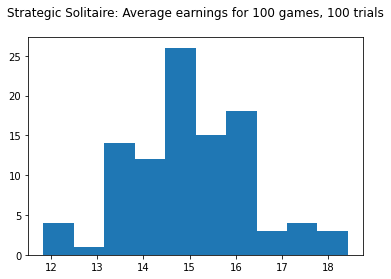

In [23]:
fig = plt.figure()
plt.hist(trials['earnings'])
plt.title("Strategic Solitaire: Average earnings for 100 games, 100 trials\n")
plt.show()

In [25]:
fig.savefig("strategic-earnings_for_100-trials_100-runs.jpg")

In [24]:
np.mean(trials['earnings'])

14.977250000000002

### 1000 trials of 100 runs each

In [26]:
pp = pprint.PrettyPrinter(indent = 4)

trials = {
    'wins': [],
    'earnings': [],
}
buyin_fee = 1.50
place_amount = 0.50
bonus_amount = 5.00

seed = None
verbose = False

# Run trials
for i in range(1000):
    # of 100 games each
    runs = []
    winnings = []
    for i in range(100):
        payout = 0
        play = Game()
        play.simulate(verbose = verbose, seed=seed)

        if(play.win()):
            runs.append(1)
            payout += (52*place_amount) + bonus_amount
        else:
            runs.append(0)
            placed = [np.sum([1 for card in play.ace_stacks[i].cards]) for i in list(play.ace_stacks.keys())]
            payout += np.sum(placed) * place_amount
        winnings.append(payout)
    
    trials['wins'].append(np.mean(runs))
    trials['earnings'].append(np.mean(winnings))

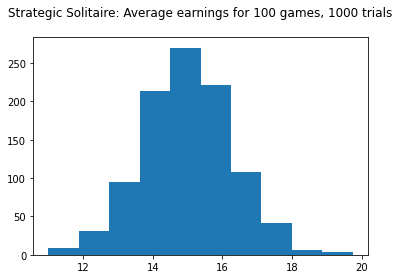

In [27]:
fig2 = plt.figure()
plt.hist(trials['earnings'])
plt.title("Strategic Solitaire: Average earnings for 100 games, 1000 trials\n")
plt.show()

In [28]:
fig2.savefig("strategic-earnings_for_1000-trials_100-runs.jpg")

In [29]:
np.mean(trials['earnings'])

15.00127

In [30]:
np.percentile(trials['earnings'], 2.5), np.percentile(trials['earnings'], 97.5)

(12.43975, 17.50025)